In [1]:
!pip install --upgrade pip --quiet && pip install --upgrade --force-reinstall --quiet ~/dev/datagrep

In [2]:
RANDOM_SEED = 42

# Monte Carlo Methods

In this notebook, you will write your own implementations of many Monte Carlo (MC) algorithms. 

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

### Part 0: Explore BlackjackEnv

We begin by importing the necessary packages.

In [3]:
import sys
import numpy as np
from collections import defaultdict
from plot_utils import plot_blackjack_values, plot_policy

from datagrep.agents import Agent
from datagrep.environments import Environment

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [4]:
env = Environment('Blackjack-v0', seed=RANDOM_SEED)
agent = Agent(seed=RANDOM_SEED)

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [5]:
agent.sense(env)

SenseResult(observation=None, available_actions=[0, 1], available_action_probabilities=[0.5, 0.5])

Execute the code cell below to play Blackjack with a random policy.  

(_The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

In [6]:
for i_episode in range(3):
    env.reset()

    while True:
        observation, available_actions, _ = agent.sense(env)
        action, reward, done = agent.act(env, observation, available_actions)

        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

End game! Reward:  -1.0
You lost :(

End game! Reward:  1.0
You won :)

End game! Reward:  1.0
You won :)



### Part 1: MC Prediction

In this section, you will write your own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [7]:
def observation_wrapper(observation, available_actions):
    available_action_probabilities = (
        [0.8, 0.2] if observation[0] > 18 else [0.2, 0.8]
    )
    return observation, available_actions, available_action_probabilities

def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    bj_env.reset()

    while True:
        (
            observation,
            available_actions,
            available_action_probabilities,
        ) = agent.sense(env)

        action, reward, done = agent.act(
            env, observation, available_actions, available_action_probabilities
        )

        episode.append((observation, action, reward))

        if done:
            break

    return episode

agent = Agent(observation_wrapper=observation_wrapper)

Execute the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit_stochastic` function.*)

In [8]:
for i in range(3):
    print(generate_episode_from_limit_stochastic(env))

[((7, 4, False), 0, 1.0)]
[((16, 4, False), 0, 1.0)]
[((9, 4, False), 0, 1.0)]


Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [9]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # loop over episodes
    for i_episode in range(1, num_episodes + 1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        episode = generate_episode(env)
        agent.learn([episode], gamma)

    return agent.quality_function

Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

In [10]:
# obtain the action-value function
quality_predictor = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

Episode 500000/500000.

In [11]:
Q = {}

for current_sum in list(range(32)):
    for dealers_card in list(range(11)):
        for usable_ace in (True, False):
            vals = []

            for action in (0, 1):
                obs = (current_sum, dealers_card, usable_ace)
                vals.append(quality_predictor.predict_action_value(obs, action))

            Q[obs] = vals

In [12]:
Q[(4, 1, False)]

[-0.8095238095238095, -1.0]

In [13]:
Q

{(0, 0, True): [0.0, 0.0],
 (0, 0, False): [0.0, 0.0],
 (0, 1, True): [0.0, 0.0],
 (0, 1, False): [0.0, 0.0],
 (0, 2, True): [0.0, 0.0],
 (0, 2, False): [0.0, 0.0],
 (0, 3, True): [0.0, 0.0],
 (0, 3, False): [0.0, 0.0],
 (0, 4, True): [0.0, 0.0],
 (0, 4, False): [0.0, 0.0],
 (0, 5, True): [0.0, 0.0],
 (0, 5, False): [0.0, 0.0],
 (0, 6, True): [0.0, 0.0],
 (0, 6, False): [0.0, 0.0],
 (0, 7, True): [0.0, 0.0],
 (0, 7, False): [0.0, 0.0],
 (0, 8, True): [0.0, 0.0],
 (0, 8, False): [0.0, 0.0],
 (0, 9, True): [0.0, 0.0],
 (0, 9, False): [0.0, 0.0],
 (0, 10, True): [0.0, 0.0],
 (0, 10, False): [0.0, 0.0],
 (1, 0, True): [0.0, 0.0],
 (1, 0, False): [0.0, 0.0],
 (1, 1, True): [0.0, 0.0],
 (1, 1, False): [0.0, 0.0],
 (1, 2, True): [0.0, 0.0],
 (1, 2, False): [0.0, 0.0],
 (1, 3, True): [0.0, 0.0],
 (1, 3, False): [0.0, 0.0],
 (1, 4, True): [0.0, 0.0],
 (1, 4, False): [0.0, 0.0],
 (1, 5, True): [0.0, 0.0],
 (1, 5, False): [0.0, 0.0],
 (1, 6, True): [0.0, 0.0],
 (1, 6, False): [0.0, 0.0],
 (1, 7, 

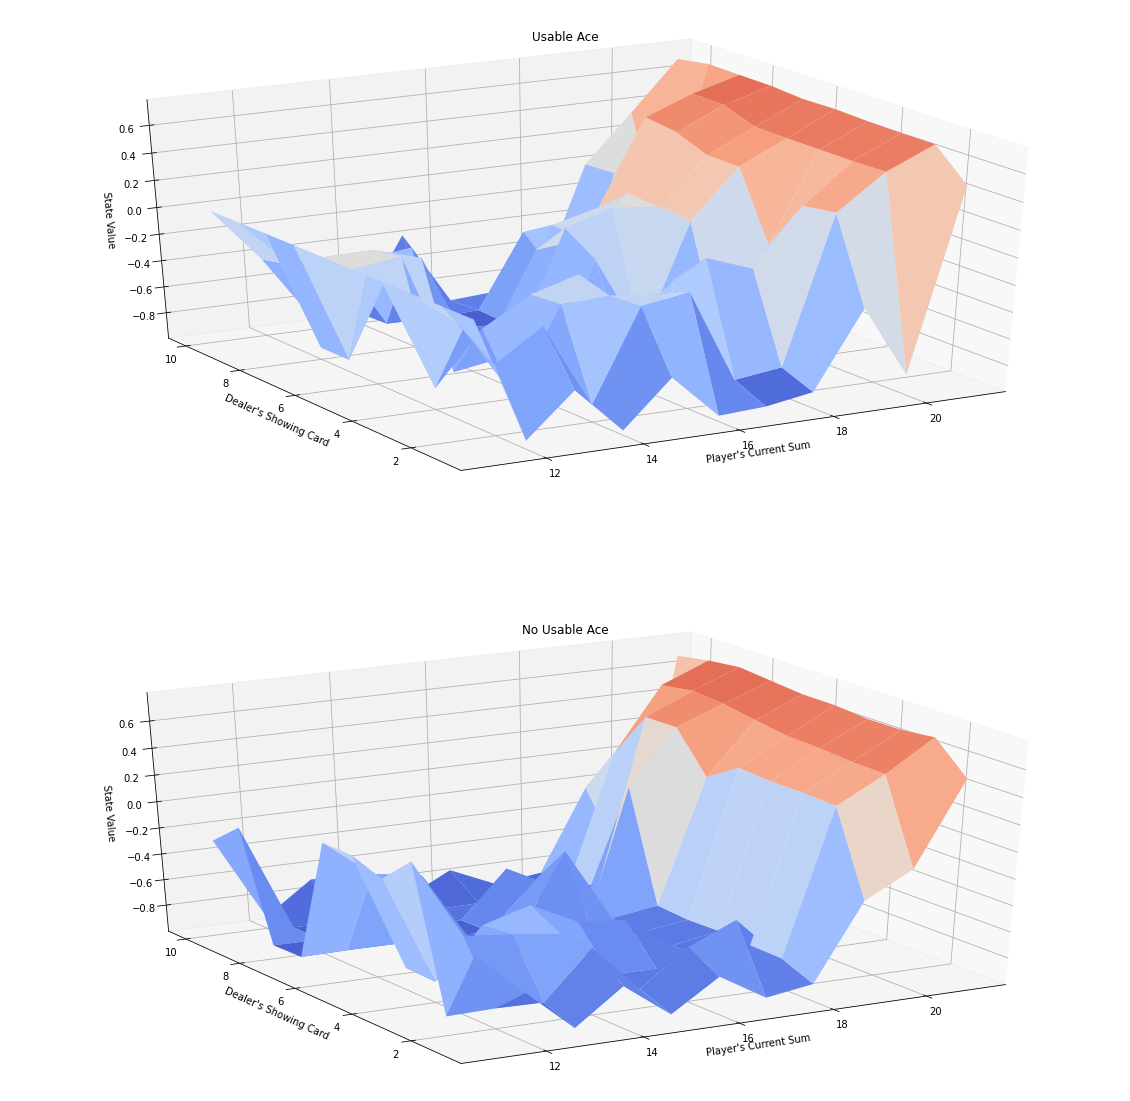

In [14]:
# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Part 2: MC Control

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [15]:
agent = Agent(observation_wrapper=observation_wrapper)

In [16]:
def mc_control(env, num_episodes, alpha, gamma=1.0):
#     nA = env.action_space.n
    # initialize empty dictionary of arrays
#     Q = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        episode = generate_episode_from_limit_stochastic(env)
        agent.learn([episode], gamma)

    return agent.policy_function, agent.quality_function
#     return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.  Note that you should fill in your own values for the `num_episodes` and `alpha` parameters.

In [17]:
# obtain the estimated optimal policy and action-value function
policy_predictor, quality_predictor = mc_control(env, 1000000, alpha=1)

Episode 1000000/1000000.

Next, we plot the corresponding state-value function.

In [18]:
Q = {}

for current_sum in list(range(32)):
    for dealers_card in list(range(11)):
        for usable_ace in (True, False):
            vals = []

            for action in (0, 1):
                obs = (current_sum, dealers_card, usable_ace)
                vals.append(quality_predictor.predict_action_value(obs, action))

            Q[obs] = vals

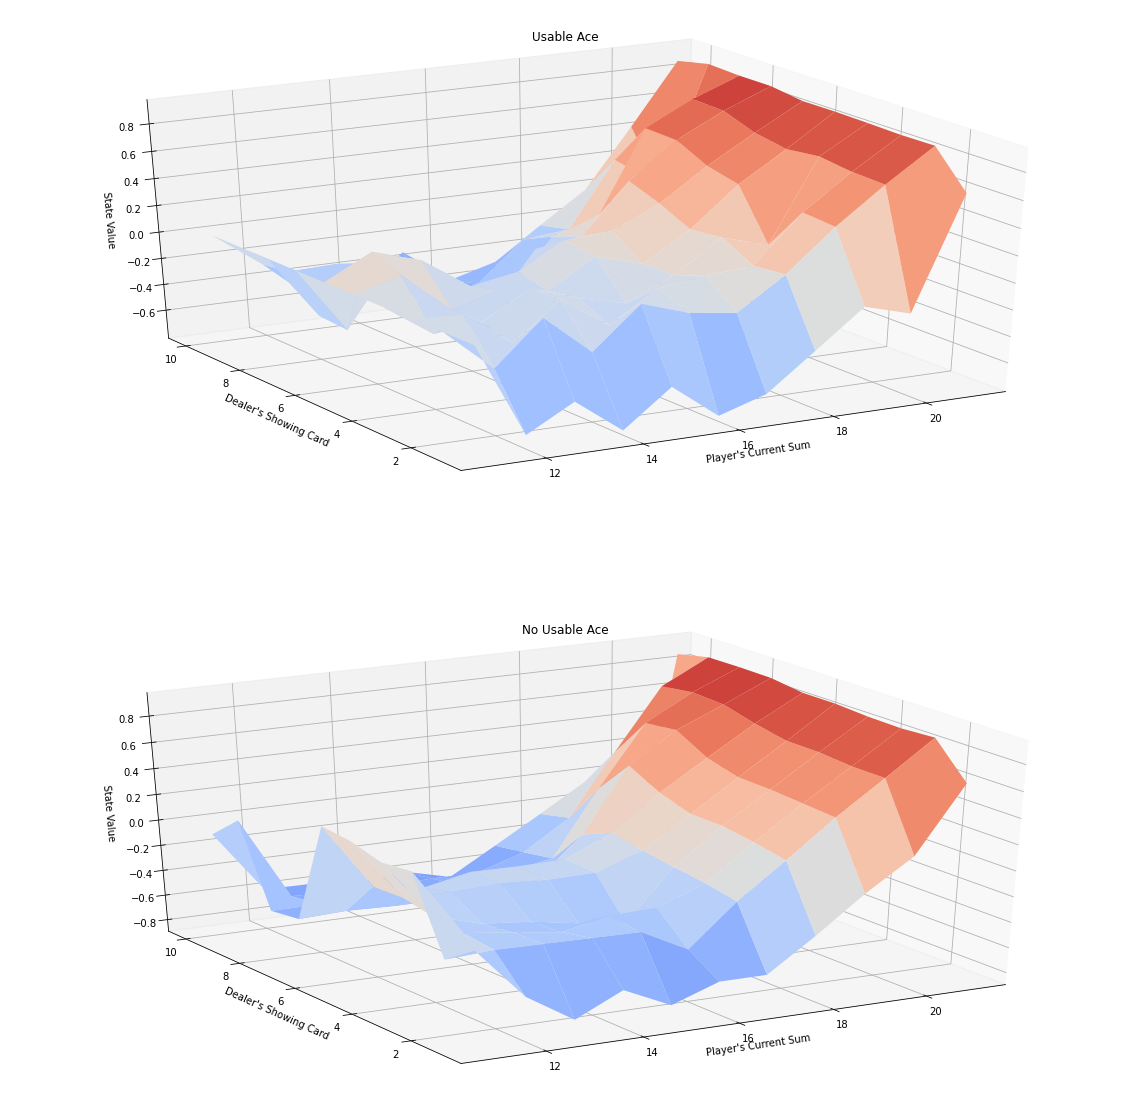

In [19]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, we visualize the policy that is estimated to be optimal.

In [20]:
policy = {}

for current_sum in list(range(32)):
    for dealers_card in list(range(11)):
        for usable_ace in (True, False):
            vals = []

            for action in (0, 1):
                obs = (current_sum, dealers_card, usable_ace)
                vals.append(quality_predictor.predict_action_value(obs, action))

            policy[obs] = 0 if vals[0] > vals[1] else 1

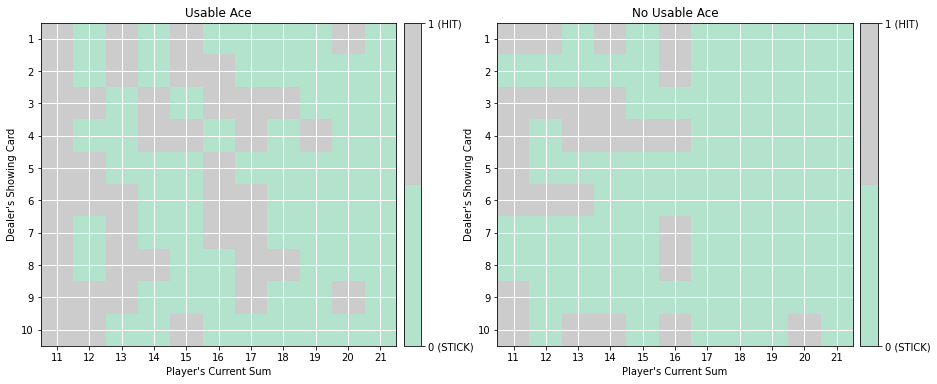

In [21]:
# plot the policy
plot_policy(policy)

The **true** optimal policy $\pi_*$ can be found in Figure 5.2 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)